# Create Figure 1

Left panel = seas ratio, climatology 

Right panel = time series of seasonal means 

Note: requires raw time series for right panel, which are too large to be included in the repository, but can be downloaded from the ESGF.

In [1]:
import xarray as xr
import numpy as np
import geopandas as gpd
import pandas as pd
from scipy import stats as sstats
import shapely
import os
import glob
import re
from matplotlib import pyplot as plt
from matplotlib import patches as mpatches
import matplotlib as mpl
import matplotlib.ticker as mticker
from cartopy import crs as ccrs
import cmocean
import warnings
from tqdm.notebook import tqdm


from funcs_support import get_params,get_filepaths,subset_to_srat,area_mean,id_timeframe,utility_print
from funcs_load import load_raws
dir_list = get_params()

extra_fonts = {'lato':mpl.font_manager.FontProperties(fname=dir_list['aux']+'fonts/Lato-Regular.ttf'),
 'lato-bold':mpl.font_manager.FontProperties(fname=dir_list['aux']+'fonts/Lato-Bold.ttf')}

## Load left panel data

In [2]:
# Set domain of left panel figure
coords = {'gha':[28,52,-10,20],
          'study':[32,52,-3,12.5]}
subset_params_gha = {'lat':slice(*coords['gha'][2:4]),
                     'lon':slice(*coords['gha'][0:2])}
subset_params_studyreg = {'lat':slice(*coords['study'][2:4]),
                          'lon':slice(*coords['study'][0:2])}

# Load CHIRPS seas ratio data for left panel
srat = (xr.open_dataset('/dx02/kschwarz/climate_proc/CHIRPS/pr_doyavg_CHIRPS_historical_seasstats_dunning_19810101-20221231_Africa.nc').
        seas_ratio.sel(**subset_params_gha))

# Load CHIRPS data for climatology
clim = xr.open_dataset('/dx01/kschwarz/climate_raw/CHIRPS/pr_day_CHIRPS_historical_obs_19810101-20221231_Africa.nc')
clim = clim.sel(**subset_params_studyreg).load()
# Get regional average over study region
clim = area_mean(subset_to_srat(clim))
# Get seasonal average
clim = clim.groupby('time.dayofyear').mean()

## Load right panel data

In [3]:
df = get_filepaths()
df = df.query('varname == "pr" and freq == "Amon"')
df = df.loc[[exp in ['historical','amip','ssp245','ssp585'] for exp in df.exp.values],:]
# Make sure to only grab one file per run / model / experiment
df = df.groupby(['model','exp','run']).apply(id_timeframe,'latest','df',include_groups=False).reset_index()

In [4]:
subset_params = {'time':slice('1981-01-01','2099-12-30'),
                 'lat':slice(-3,12.5),'lon':slice(32,55)}
anom_timeframe = {'year':slice(1981,2000)}

In [5]:
dssp = dict()

try_inferring_dates_from_fn = True

for exp in ['obs','historical','amip','ssp245','ssp585']:
    dssp[exp] = dict()

    # Obs separately
    if exp != 'obs':
        df_tmp = df.query('exp == "'+exp+'" and suffix == "HoAfrica"')
        df_tmp = df_tmp.loc[[run != 'obs' for run in df_tmp.run.values],:]
    else:
        df_tmp = df.query('exp == "historical" and run == "obs"')

    for row in tqdm([row for row in df_tmp.iterrows()]):
        # Load
        try:
            ds = xr.open_dataset(row[1]['path'])
        except:
            if try_inferring_dates_from_fn:
                try:
                    # Some files have dates in a format that cftime can't do,
                    # in those cases, try to infer from filenames
                    ds = xr.open_dataset(row[1]['path'],decode_times = False)
                    # Infer from filename time range, assuming monthly, 
                    # with center on the 16th of each month
                    ds['time'] = pd.date_range(*re.split(r'-',row[1]['time']),freq='1MS') + pd.DateOffset(days=15)
                except:
                    del ds
                    warnings.warn('Issue loading file '+row[1]['path']+', skipping.')
                    continue
                

        if len(ds.pr.dims) == 2:
            print(row[1]['model']+' is 1D, skipping for now...')
            continue

        # Subset by desired timeframe
        ds = ds.sel(**subset_params)
        # Get just MAM means
        ds = ds.isel(time=(ds.time.dt.season=='MAM')).resample(time='1YE').mean()
        # Change time dimension to year
        ds['time'] = ds.time.dt.year
        ds = ds.rename({'time':'year'})

        # Get area average 
        ds = area_mean(subset_to_srat(ds))

        # Bookkeeping for future concat
        ds = ds.expand_dims({'model':[row[1]['model']],
                             'run':[row[1]['run']]})
        ds = ds.stack(idv = ['model','run'])

        # Add to dict
        dssp[exp][''.join(ds.idv.values[0])] = ds

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/617 [00:00<?, ?it/s]

ICON-ESM-LR is 1D, skipping for now...
ICON-ESM-LR is 1D, skipping for now...
ICON-ESM-LR is 1D, skipping for now...
ICON-ESM-LR is 1D, skipping for now...
ICON-ESM-LR is 1D, skipping for now...


  0%|          | 0/176 [00:00<?, ?it/s]

  0%|          | 0/340 [00:00<?, ?it/s]

  0%|          | 0/303 [00:00<?, ?it/s]

/home/kschwarz/miniforge3/envs/climate/lib/python3.12/site-packages/xarray/coding/times.py:995: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/home/kschwarz/miniforge3/envs/climate/lib/python3.12/site-packages/xarray/core/indexing.py:630: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  array = array.get_duck_array()
/home/kschwarz/miniforge3/envs/climate/lib/python3.12/site-packages/xarray/core/indexing.py:500: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(self.get_duck_array(), dtype=dtype)


In [6]:
# Concatenate into single ds per experiment
dssp = {exp:xr.concat([ds for idv,ds in dssp[exp].items()],dim='idv')
        for exp in dssp}

In [7]:
# Get rid of extra variables from some of the obs products
dssp['obs'] = dssp['obs'][['pr']]

In [8]:
# Not sure why this is necessary, shouldn't have a 2014 year...?
for exp in ['ssp245','ssp585']:
    dssp[exp] = dssp[exp].sel(year=slice(2015,None))

In [9]:
# Create single time series from historical through ssp245
for exp in ['ssp245','ssp585']:
    dssp['hist-'+exp] = xr.concat([dssp['historical'],dssp[exp]],
          dim='year',join='outer')

In [10]:
# Calculate anomaly vs. 1981-2000 mean
for exp in dssp:
    dssp[exp]['pranom'] = dssp[exp]['pr'] / dssp[exp]['pr'].sel(**anom_timeframe).mean('year')
    #dssp[exp]['pranom'] = (dssp[exp]['pr'] / dssp[exp]['pr'].sel(**anom_timeframe).mean('year').groupby('model').mean())



## Create figure

/home/kschwarz/projects/future_stability/figures/figure1.pdf saved!
/home/kschwarz/projects/future_stability/figures/figure1.png saved!


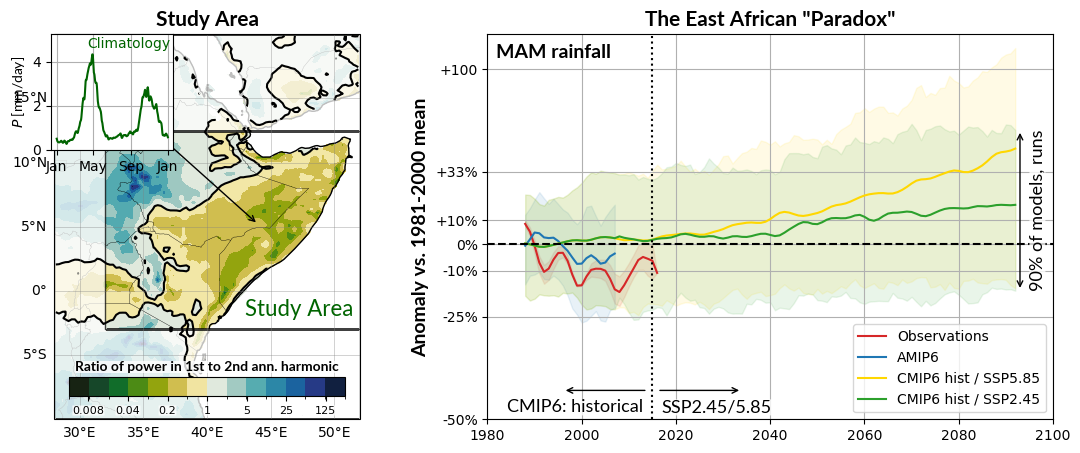

In [21]:
#-------------------------------------
# SETUP
#-------------------------------------
save_fig = True
output_fn = dir_list['figs']+'figure1'
#### Left panel params

# Colorbar parameters for the harmonic ratio
srat_cbar_params = {'vmin':-5.6,'vmax':5.6,
                    'levels':15,'cmap':cmocean.cm.delta_r}
#srat_clabel = 'Log ratio of 1st to 2nd ann. harmonic'
srat_clabel = 'Ratio of power in 1st to 2nd ann. harmonic'


#### Right panel params
roll_w = 15
# Get gaussian weight vector for rolling avg
weight = xr.DataArray(sstats.norm(0, 1).pdf(np.arange(-5,5,10/roll_w)), dims=['window'])
# Normalize by weight sum
weight = weight/weight.sum()

obs_mods = ['CHIRPS','GPCC-full','GPCP']

colors = {'obs':'tab:red',
          'amip':'tab:blue',
          'hist-ssp585':'gold',
          'hist-ssp245':'tab:green'}

exp_labels = {'obs':'Observations',
              'amip':'AMIP6',
              'hist-ssp245':'CMIP6 hist / SSP2.45',
              'hist-ssp585':'CMIP6 hist / SSP5.85'}

text_bkgrd_style = {'facecolor':'white','edgecolor':'none',
                          'boxstyle':'round','alpha':0.8,'pad':0}

#fig,axs = plt.subplots(1,2,width_ratios=[1,2],
#                       figsize=(12,5))

# Specify figure size
fig = plt.figure(figsize=(13,5))
# Now create the tiled board
spec = fig.add_gridspec(1,3,width_ratios = [1,0.001,1.75])
axs = [None]*2

#-------------------------------------
# LEFT PANEL
#-------------------------------------
axs[0] = fig.add_subplot(spec[0],projection=ccrs.PlateCarree())

#--------- Plot harmonic ratio ---------
# Plot log harmonic ratio
np.log(srat).plot.contourf(transform=ccrs.PlateCarree(),
                  **srat_cbar_params,add_colorbar=False,
                           ax=axs[0])
# Plot boundary between single-dominant / double-dominant
# areas
srat.plot.contour(transform=ccrs.PlateCarree(),
                  levels=[0,1],colors=['k'],
                 ax=axs[0])

#--------- Plot annotations ---------
# Coasts
axs[0].coastlines()

# Get ISO-standard borders
gdf = gpd.read_file('/dx01/kschwarz/aux_data/ne_10m_admin_0_countries_iso/ne_10m_admin_0_countries_iso.shp')
# Add borders to plot
gdf.cx[subset_params_gha['lon'],subset_params_gha['lat']].plot(ax=axs[0],facecolor='none',edgecolor='k',
                                                       linestyle='-',linewidth=0.15,
                                                       transform=ccrs.PlateCarree())

# Set extent
axs[0].set_extent(coords['gha'])

# Add shading to show study area
area_def = shapely.Polygon(shell = [[coords['gha'][0],coords['gha'][2]],
                         [coords['gha'][1],coords['gha'][2]],
                         [coords['gha'][1],coords['gha'][3]],
                         [coords['gha'][0],coords['gha'][3]]],
                holes = [[[coords['study'][0],coords['study'][2]],
                         [coords['study'][0],coords['study'][3]],
                         [coords['study'][1],coords['study'][3]],
                         [coords['study'][1],coords['study'][2]]]])

axs[0].add_geometries([area_def],crs=ccrs.PlateCarree(),
                  edgecolor='k',facecolor='w',alpha=0.75)

# Add gridlines
gl = axs[0].gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=0.5, color='grey', alpha=0.5, linestyle='-')
gl.top_labels = False
gl.right_labels = False
gl.xlocator = mticker.FixedLocator([30,35,40,45,50])

# Title
axs[0].set_title('Study Area',font = extra_fonts['lato-bold'],fontsize=15)

# Annotations
axs[0].annotate('Study Area',[51.5,-2.25],transform = ccrs.PlateCarree(),
                va='bottom',ha='right',color='darkgreen',fontsize=16,
                font = extra_fonts['lato'])

# Colorbar
posn = axs[0].get_position()
cax = fig.add_axes([posn.x0 + 0.05*posn.width,
                      posn.y0 + 0.2*posn.width,
                      0.9*posn.width , posn.height*0.05])
levels = mpl.ticker.MaxNLocator(nbins=srat_cbar_params['levels']).tick_values(srat_cbar_params['vmin'],srat_cbar_params['vmax'])
norm = mpl.colors.BoundaryNorm(levels, ncolors=srat_cbar_params['cmap'].N, clip=True)
sm = plt.cm.ScalarMappable(cmap=srat_cbar_params['cmap'],norm=norm)
cb = plt.colorbar(sm,cax=cax,orientation='horizontal')
cb.set_label(srat_clabel,fontsize=10,font = extra_fonts['lato-bold'],bbox=text_bkgrd_style)
cb.ax.xaxis.set_label_position('top')
cb.ax.tick_params(labelsize=8)
# Put box behind labels so they're legible
#cb.ax.set_xticks(cb.ax.get_xticks())
cb.ax.set_xticks(np.log(np.array([1/125,1/25,1/5,1,5,25,125])))
tick_labels = [str("{0:.3g}".format(np.exp(t))) for t in cb.ax.get_xticks()]
#tick_labels = [str(np.round(t,1)) for t in cb.ax.get_xticks()]
cb.ax.set_xticklabels(tick_labels,
                      minor=False,
                      bbox = text_bkgrd_style)



#--------- Plot climatology ---------
climax = fig.add_axes([posn.x0 - 0.01*posn.width,
                      posn.y1 - 0.3*posn.height,
                       0.4*posn.width,0.3*posn.height])

# Get gaussian weight vector for rolling avg
weight = xr.DataArray(sstats.norm(0, 1).pdf(np.arange(-5,5,10/roll_w)), dims=['window'])
# Normalize by weight sum 
weight = weight/weight.sum()

# Plot rolling average climatology
((clim.pad({'dayofyear':int(roll_w/2)},mode='wrap').pr.
 rolling(dayofyear=roll_w,center=True).construct('window').dot(weight))[int(roll_w/2):-int(roll_w/2)].
 plot(color='darkgreen',ax=climax))


#--------- Plot climatology annotations ---------
# Change x axis to month names
doys = np.array(pd.date_range('2001-01-01','2002-02-01',freq='4MS').dayofyear)
doys[-1] = doys[-1]+365
plt.xticks(doys,pd.date_range('2001-01-01','2002-02-01',freq='4MS').strftime('%b'))

# Axis labels
climax.set_xlabel('')
climax.set_ylabel(r'$P$ [mm/day]',
                 font=extra_fonts['lato'])

climax.set_ylim([0,5.25])
climax.grid()

# Arrow to middle of study area 
axs[0].annotate('',xy=[44,5.2],xytext=[35,13.2],
            arrowprops = {'arrowstyle':'->'})

# Titles
climax.annotate('Climatology',[0.975,0.975],
                xycoords = 'axes fraction',
                va='top',ha='right',color='darkgreen')


#-------------------------------------
# RIGHT PANEL
#-------------------------------------
axs[1] = fig.add_subplot(spec[2])

#--------- Plot ---------

for exp in colors:
    # Get smoothed data
    plot_data = dssp[exp].pranom.rolling(year=roll_w,center=True).construct('window').dot(weight)
    
    # Subset by obs product
    if exp == 'obs':
        plot_data = plot_data.where([mod in obs_mods for mod in plot_data.model])
    
    # Plot mean
    plot_data.mean('idv').plot(color=colors[exp],label=exp_labels[exp],
                               ax=axs[1])

    # Plot 90% range
    with warnings.catch_warnings():
        # To silence all-NaN slice warning
        warnings.filterwarnings('ignore')
        axs[1].fill_between(plot_data.year,
                    plot_data.quantile(0.05,dim='idv'),
                    plot_data.quantile(0.95,dim='idv'),
                    color=colors[exp],
                    alpha=0.1)

    if exp == 'hist-ssp245':
        # Get arrow explaining range
        axs[1].annotate('',
            *[(x,y) for x,y in zip([int(2099-roll_w/2)+2]*2,
                  plot_data.sel(year=2099-int(roll_w/2)).quantile([0.05,0.95],dim='idv').values)],
            arrowprops = {'arrowstyle':'<->'})

        # Label arrow
        axs[1].annotate(r'90% of models, runs',
                    [int(2099-roll_w/2)+4,
                     plot_data.sel(year=2099-int(roll_w/2)).quantile(0.5,dim='idv').values],
                    rotation=90,
                    ha='left',va='center',
                        fontsize=13,
                    bbox=text_bkgrd_style,font = extra_fonts['lato'])
#------------ Plot annotations ------------
# Add dotted line at the hist/ssp transition
axs[1].axvline(2015,color='k',linestyle=':')

# Add 0 line
axs[1].axhline(1,color='k',linestyle='--')

# Make yaxis log
axs[1].set_yscale('log')

# Manually set locations of yaxis ticks
tick_spots = np.array([1/2,3/4,9/10,1,11/10,4/3,2/1])
tick_labels = np.array([str(int(np.round((t-1)*100,0)))+r'%' for t in tick_spots])
tick_labels[tick_spots>1] =  ['+'+t for t in tick_labels[tick_spots>1]]
axs[1].set_yticks(ticks = tick_spots,
              labels = tick_labels)
# To avoid extra phantom labels showing up
plt.minorticks_off()

# Add grid
axs[1].grid()
axs[1].set_xlim([1980,2100])

# Add legend
axs[1].legend(loc='lower right')

# Axes annotations
axs[1].set_ylabel('Anomaly vs. '+str(anom_timeframe['year'].start)+'-'+
             str(anom_timeframe['year'].stop)+' mean',
             fontsize=14,font = extra_fonts['lato-bold'])
axs[1].set_xlabel('')

# Title
axs[1].set_title(r'The East African "Paradox"',font = extra_fonts['lato-bold'],fontsize=15)

# Further annotations
axs[1].annotate('MAM rainfall',
            xy=[0.015,0.975],
            xycoords = 'axes fraction',
            fontsize=14,
            va='top',ha='left',font = extra_fonts['lato-bold']) 

axs[1].annotate('CMIP6: historical',
            xy=[2013,0.01],
            xycoords = ('data','axes fraction'),
            fontsize=13,bbox=text_bkgrd_style,
            va='bottom',ha='right',font = extra_fonts['lato'])
axs[1].annotate('SSP2.45/5.85',
            xy=[2017,0.01],
            xycoords = ('data','axes fraction'),
            fontsize=13,bbox=text_bkgrd_style,
            va='bottom',ha='left',font = extra_fonts['lato'])

axs[1].annotate('',xy=[2016,0.075],xytext = [2016+18,0.075],
            xycoords = ('data','axes fraction'),
            arrowprops = {'arrowstyle':'<-'})
axs[1].annotate('',xy=[2014,0.075],xytext = [2014-18,0.075],
            xycoords = ('data','axes fraction'),
            arrowprops = {'arrowstyle':'<-'})

#-------------------------------------
# OUTPUT
#-------------------------------------
if save_fig:
    utility_print(output_fn)